In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.utils.data as data
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import pytorch_models
import imp
import torchaudio as ta
import torchaudio
import torchvision as tv
import matplotlib.pyplot as plt
from IPython.display import Audio
import os, random
import pandas as pd
import mir_utils as miru
from torch.utils.data import Dataset, DataLoader
from pytorch_models import *
import librosa
import librosa.display
import pytorch_models as pm
imp.reload(miru)
imp.reload(pytorch_models)
SR=44100

#functions
spec=torchaudio.functional.spectrogram
#takes a billion years so commented
audio_frames=miru.audioFrames(loadCache=True)

def getMeanLength(x):
    gl=x.apply(lambda z: len(z["audio"]),axis=1)
    print(gl.mean()/SR,gl.mean(),x["label"].iloc[0])
    
# audio_frames.groupby(by=["label_num"]).apply(lambda x:getMeanLength(x))
# getMeanLength(audio_frames)


def getRandAud():
    classes=os.listdir("./dk_data/")
    rand_class=random.choice(classes)
#     rand_class="stacks"
    rand_sample=random.choice(os.listdir("./dk_data/%s/"%(rand_class,)))
    return "./dk_data/"+rand_class+"/"+rand_sample
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# list(zip(uniques,range(0,len(uniques))))
#drop shakers, pianos and guitars
audio_frames=audio_frames.loc[~audio_frames["label"].isin(["shake","synth_noise","tom","tom_high","guitar","piano","stacks"])]
#split the dataframe into 2 seperate ones:
drum_frames=audio_frames.loc[~audio_frames["label"].isin(["stacks","guitar","piano"])]
not_drum_frames=audio_frames.loc[audio_frames["label"].isin(["stacks","guitar","piano"])]



In [2]:
#drum only classification
dLabels, dUniques=pd.factorize(drum_frames["label"].tolist())
ndLabels, ndUniques=pd.factorize(not_drum_frames["label"].tolist())

drum_frames["label_num"]=dLabels
not_drum_frames["label_num"]=ndLabels+len(dUniques)

allU=np.concatenate([dUniques,ndUniques])
lmap=list(zip(allU,range(len(allU))))
all_labels=np.concatenate((dUniques,ndUniques))
print(all_labels)


#get weights for each group
x=drum_frames.groupby(["label"]).agg("count")["path"]
y=drum_frames.groupby(["label_num"]).agg("count")["path"]
print(y)
weights=torch.tensor([1000/w for w in y.tolist()])
print("weights based on sample count",weights)
print(len(dUniques))

['tom_low' 'snare' 'hihat_closed' 'rim' 'clap' 'kick' 'hihat_open'
 'tom_mid']
label_num
0    188
1    731
2    187
3    105
4    118
5    648
6    280
7    139
Name: path, dtype: int64
weights based on sample count tensor([5.3191, 1.3680, 5.3476, 9.5238, 8.4746, 1.5432, 3.5714, 7.1942])
8


In [3]:
class audioDataset(torch.utils.data.Dataset):
    def __init__(self,audio_frame,root_dir, task="keep_all",transform=None):
        self.root_dir=root_dir
        self.task=task
        self.audio_frame=audio_frame
        self.transform = transform
        self.minLength=SR
#         self.minLength=SR//4
        self.frame_pruning()
    def __len__(self):
        return len(self.audio_frame)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        rows=self.audio_frame.iloc[idx]

        signals,labels=rows["audio"].tolist()[0:SR],rows["label_num"].tolist()
        signals,labels=torch.tensor(signals),torch.tensor(labels)
        
        nz=np.max((self.minLength-signals.shape[0],0))
        signals=torch.cat([signals[0:self.minLength],torch.zeros(nz)],dim=0)

        sound={"signal":signals,"label":labels}
        
        if self.transform:
            sound = self.transform(sound)

        return sound
    
    def frame_pruning(self):
        #drum vs not drum classification:
        drum_label_numbers=range(len(dUniques))
        if self.task=="dvn":
            self.audio_frame.loc[self.audio_frame["label_num"].isin(drum_label_numbers),"label_num"]=0
            self.audio_frame.loc[~self.audio_frame["label_num"].isin(drum_label_numbers),"label_num"]=1
        #drum type classification
        if self.task=="dvd":
            self.audio_frame=self.audio_frame.loc[self.audio_frame["label_num"].isin(drum_label_numbers)]
        if self.task=="keep_all":
            pass
            
ds=audioDataset(pd.concat([drum_frames,not_drum_frames]),"./",task="dvd",)
idx=np.random.randint(0,len(ds),5)
ds[np.random.randint(len(ds))]

all_frames=pd.concat([drum_frames,not_drum_frames])
train=all_frames.sample(frac=0.80,random_state=420) #random state is a seed value
test=all_frames.drop(train.index)


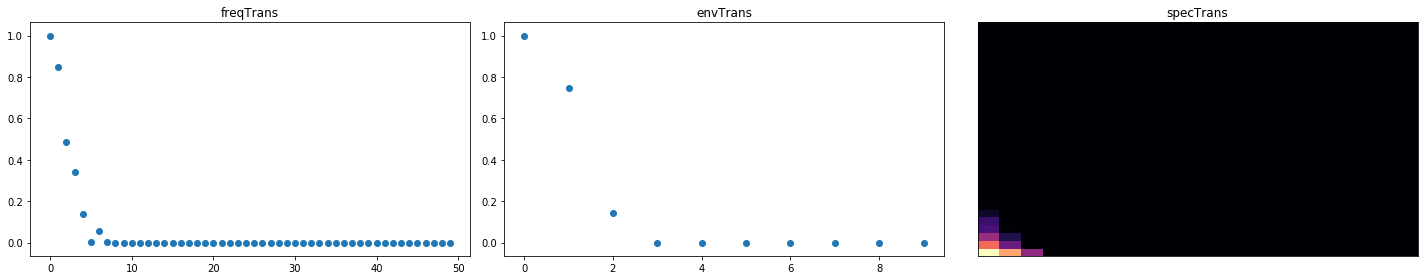

('kick', 5) tensor(5) 44100


In [344]:

#defining transformations
class freqTrans(object):
    def __init__(self,num_mels=50,SR=SR):
        self.num_mels=num_mels
        self.ampT=torchaudio.transforms.AmplitudeToDB(stype='power', top_db=30)
        self.melF=torchaudio.transforms.MelScale(n_mels=self.num_mels, sample_rate=SR, f_min=30.0, f_max=None, n_stft=None)
        
    def __call__(self, sample):
        wf,label=sample["signal"],sample["label"]
        wf=wf.reshape(-1,len(wf))
        sample_length=SR//4
        wf=wf[:,0:24000]
        num_bins=wf[0].shape[0]
        win_length=num_bins
        hop_step=sample_length//(self.num_mels)
        window=torch.tensor([1]*win_length)
        s=spec(wf, 100, window, num_bins, hop_step, win_length,2,normalized=False)
        s=self.melF(s)
        s=self.ampT(s)
        freq=s.sum(axis=0).sum(axis=1)
        freq=freq-freq.min()
        freq=freq/freq.max()
        freq[torch.isnan(freq)]=0
        return {"feats":freq.detach(),"label":label}

class envTrans(object):

    def __init__(self,num_mels=1,SR=SR):
        self.env_size=9
        self.num_mels=num_mels
        self.amp=torchaudio.transforms.AmplitudeToDB(stype='power', top_db=60)
        self.melEnv=torchaudio.transforms.MelScale(n_mels=self.num_mels, sample_rate=SR, f_min=30.0, f_max=None, n_stft=None)
    def __call__(self, sample):
        wf,label=sample["signal"],sample["label"]

        wf=wf.reshape(-1,len(wf))
        signal=wf.numpy()[0]


        sample_length=SR
        num_bins=wf[0].shape[0]
        win_length=SR//10
        hop_step=SR//self.env_size
        window=torch.tensor([1]*win_length)
        s=spec(wf, 0, window,win_length, hop_step, win_length,2,normalized=False)
        s=self.melEnv(s)
        s=self.amp(s)

        #normalizing
        env=s.sum(axis=0).sum(axis=0)
        env=env-env.min()
        env=env/env.max()
        env[torch.isnan(env)]=0
        
#         fr,hl=win_length,hop_step
#         zc=librosa.feature.zero_crossing_rate(signal,frame_length=2048, hop_length=hop_step)
#         sc=librosa.feature.spectral_centroid(signal,hop_length=512,sr=SR)
#         print(zc.shape,sc.shape)
#         print(zc,sc)
        num_padding=torch.max(torch.tensor([self.env_size+1-env.shape[0],0]))
        env_vec=torch.cat([env.detach(),torch.zeros(num_padding)],dim=0)
        return {"feats":env_vec.detach(),"label":label}


    
class feats_and_env(object):
    def __init__(self,feat_mels=50,env_mels=1):
        self.ft=freqTrans(num_mels=feat_mels)
        self.et=envTrans(num_mels=env_mels)

    def __call__(self, sample):
            combined_feats=torch.cat((self.ft(sample)["feats"],self.et(sample)["feats"]))
            return {"feats":combined_feats,"label":sample["label"]}
        

#Apply each of the above transforms on sample.
fig = plt.figure(figsize=(20,4))
sample = ds[np.random.randint(len(ds))]
# freq_train = audioDataset(train,".",task="dvd")
# f_train_loader= DataLoader(freq_train, batch_size=1, num_workers=1)
# sample=iter(f_train_loader).next()
# s={"signal":sample["signal"][0],"label":sample["label"][0]}
# sample=s

class specTrans(object):
    def __init__(self,num_mels=50,SR=SR):
        self.num_mels=num_mels
        self.ampP=torchaudio.transforms.AmplitudeToDB(stype='magnitude',top_db=60)
        self.melP=torchaudio.transforms.MelScale(n_mels=self.num_mels, sample_rate=SR,n_stft=None)
        self.norm= transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    def __call__(self, sample):
        
        wf,label=sample["signal"],sample["label"]
        wf=wf.reshape(-1,len(wf))
        sample_length=SR

        num_bins=wf[0].shape[0]
        win_length=SR//17
        hop_step=SR//19
        window=torch.tensor([1]*win_length)
        s=spec(wf, 0, window, num_bins, hop_step, win_length,2,normalized=False)
        s=self.melP(s)
        s=self.ampP(s)
        s = s - s.min()
        s = s/s.abs().max()

        freq=s
#         freq=self.norm(s)
        return {"feats":freq.detach(),"label":label}
    
tfList=[freqTrans(50),envTrans(num_mels=1,SR=SR),specTrans(30)]
for i, tsfrm in enumerate(tfList):
    transformed_sample = tsfrm(sample)
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    ft=transformed_sample["feats"]
    if len(ft.shape)==1:
        plt.scatter(y=ft,x=range(0,len(ft)))
    else:

        ft=ft.detach().numpy()[0]
#         print(ft.shape,ft)
        librosa.display.specshow(ft)

plt.show()
print(lmap[transformed_sample["label"].item()],transformed_sample["label"],len(sample["signal"]))


Audio(sample["signal"],rate=SR,autoplay=True)


## FC + env frequency

In [7]:
#define a model for freq categorization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE, D_in,D_out =32,50,2
# H1,H2,H3=100,50,10

# combined_feats=torch.cat((tfList[0](sample)["feats"],tfList[1](sample)["feats"]))

fne=feats_and_env()
all_frames=pd.concat([drum_frames,not_drum_frames])
train=all_frames.sample(frac=0.80,random_state=420) #random state is a seed value
test=all_frames.drop(train.index)
freq_train = audioDataset(train,".",task="dvd", transform=fne)
freq_test = audioDataset(test,".",task="dvd", transform=fne)
f_train_loader= DataLoader(freq_train, batch_size=BATCH_SIZE,shuffle=True, num_workers=12)
f_test_loader= DataLoader(freq_test, batch_size=BATCH_SIZE,shuffle=True, num_workers=4)

import imp
imp.reload(pm)  
freq_model=pm.env_freq_Model(D_in=60,H1=30,H2=10,H3=10,D_out=len(dUniques),device=device)

freq_model.to(device)

loss_fn = torch.nn.CrossEntropyLoss(weight=weights.to(device))

learning_rate = 0.001
optimizer = torch.optim.Adam(freq_model.parameters(), lr=learning_rate)
epochs=20

for i in range(epochs):
    running_loss = 0.0
    print("hi")
    for j,x in enumerate(f_train_loader):

        f,l=x["feats"].to(device),x["label"].to(device)
  
        optimizer.zero_grad()            
        y_pred = freq_model(f)
        loss = loss_fn(y_pred, l)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
    correct = 0
    total = 0    
    for j,xt in enumerate(f_test_loader):
        ft,lt=xt["feats"].to(device),xt["label"].to(device)
        outputs = freq_model(ft) 
        _, predicted = torch.max(outputs.data, 1)
        total += lt.size(0)
        correct += (predicted == lt).sum().item()
        acc=(100 * correct / total)
        test_loss=running_loss/train.shape[0]
    if acc>80:
            torch.save(freq_model.state_dict(),'./models/fc/freq_env_dvd_%d_%d.pt'%(acc,running_loss))

    print('Accuracy on test: %d %%' % (acc))
    print(i,running_loss)

hi
Accuracy on test: 23 %
0 124.27184462547302
hi
Accuracy on test: 45 %
1 118.70183968544006
hi
Accuracy on test: 54 %
2 112.94091093540192
hi
Accuracy on test: 56 %
3 111.25429081916809
hi
Accuracy on test: 58 %
4 109.90462839603424
hi
Accuracy on test: 56 %
5 108.76772773265839
hi
Accuracy on test: 57 %
6 108.33759069442749
hi
Accuracy on test: 60 %
7 107.43237745761871
hi
Accuracy on test: 60 %
8 107.04125916957855
hi
Accuracy on test: 60 %
9 106.78221523761749
hi
Accuracy on test: 62 %
10 106.59706664085388
hi
Accuracy on test: 61 %
11 106.36989843845367
hi
Accuracy on test: 61 %
12 105.90120327472687
hi
Accuracy on test: 59 %
13 105.83479964733124
hi
Accuracy on test: 62 %
14 105.79120814800262
hi
Accuracy on test: 62 %
15 105.58853125572205
hi
Accuracy on test: 63 %
16 105.51547193527222
hi
Accuracy on test: 62 %
17 105.16034770011902
hi
Accuracy on test: 63 %
18 105.17090475559235
hi
Accuracy on test: 64 %
19 105.06704819202423


## ENV model

In [9]:
len_outputs=len(dUniques)+len(ndUniques)
#using env features
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_env_feats=1
BATCH_SIZE, D_in,D_out =64,num_env_feats+1,2
H1,H2,H3,H4,H5=10,10,10,5,2

et=tv.transforms.Compose([envTrans(num_env_feats)])

train=all_frames.sample(frac=0.80,random_state=420) #random state is a seed value
test=all_frames.drop(train.index)
env_train = audioDataset(train,".",task="keep_all", transform=et)
env_test = audioDataset(test,".",task="keep_all", transform=et)
env_train_loader= DataLoader(env_train, batch_size=BATCH_SIZE,shuffle=True, num_workers=6)
env_test_loader= DataLoader(env_test, batch_size=BATCH_SIZE,shuffle=True, num_workers=4)
import imp
imp.reload(pm)  

model_env = pm.env_Model(D_in=10,H1=50,H2=20,H3=4,H4=2,H5=10,D_out=len(dUniques),device=device)

# weight=torch.tensor([0.8,0.20]).to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=weights.to(device))


learning_rate = 0.001
optimizer = torch.optim.Adam(model_env.parameters(), lr=learning_rate)
epochs=80


best_loss=10**9
train_loss=0
best_acc=0
acc=0
for i in range(epochs):
    
    #should we just stop training? 
    best_acc=max(acc,best_acc)
    best_loss=min(best_loss,train_loss)
    if train_loss<best_loss or acc>=best_acc:
        current_stagnation=0
    else:
        current_stagnation=current_stagnation+1
    if current_stagnation>20:
        print("quiting due to stagnation")
        break
    
    running_loss = 0.0

    for j,x in enumerate(env_train_loader):
        f,l=x["feats"].to(device),x["label"].to(device)

        optimizer.zero_grad()            
        y_pred = model_env(f)
        loss = loss_fn(y_pred, l)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
    
    correct = 0
    total = 0    
    for j,xt in enumerate(env_test_loader):

        ft,lt=xt["feats"].to(device),xt["label"].to(device)
        outputs = model_env(ft) 
        _, predicted = torch.max(outputs.data, 1)
        total += lt.size(0)
        correct += (predicted == lt).sum().item()
    acc=(100 * correct / total)
    train_loss=running_loss
    save=False
    if acc>75 or save==True:
            torch.save(model_env.state_dict(),'./models/fc/env_dvd_%d_%d.pt'%(acc,train_loss))
    print('Accuracy on test: %d %%' % (acc,))
    print(i,train_loss)   
    


Accuracy on test: 11 %
0 62.4031982421875
Accuracy on test: 11 %
1 62.35775589942932
Accuracy on test: 10 %
2 62.18389439582825
Accuracy on test: 14 %
3 61.72076058387756
Accuracy on test: 12 %
4 61.13407516479492
Accuracy on test: 12 %
5 60.778228521347046
Accuracy on test: 13 %
6 60.609474778175354
Accuracy on test: 13 %
7 60.40416133403778
Accuracy on test: 13 %
8 60.32637429237366
Accuracy on test: 12 %
9 60.20704960823059
Accuracy on test: 15 %
10 60.105867981910706
Accuracy on test: 16 %
11 60.020484924316406
Accuracy on test: 17 %
12 59.94510781764984
Accuracy on test: 17 %
13 59.89240050315857
Accuracy on test: 20 %
14 59.790456771850586
Accuracy on test: 20 %
15 59.78508186340332
Accuracy on test: 22 %
16 59.71685290336609
Accuracy on test: 23 %
17 59.706323742866516
Accuracy on test: 24 %
18 59.656864404678345
Accuracy on test: 26 %
19 59.65443468093872
Accuracy on test: 27 %
20 59.59262001514435
Accuracy on test: 26 %
21 59.593517541885376
Accuracy on test: 26 %
22 59.529254

## FC SPEC

In [7]:
#using whole spec features
#define a model for freq categorization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pt=tv.transforms.Compose([specTrans(20)])

train=all_frames.sample(frac=0.80,random_state=420) #random state is a seed value
test=all_frames.drop(train.index)
pitch_data_train = audioDataset(train,".","keep_all", transform=pt)
pitch_data_test = audioDataset(test,".",task="keep_all", transform=pt)
pitch_train_loader= DataLoader(pitch_data_train, batch_size=BATCH_SIZE,shuffle=True, num_workers=6)
pitch_test_loader= DataLoader(pitch_data_test, batch_size=BATCH_SIZE,shuffle=True, num_workers=6)


import imp
imp.reload(pm)  
pitch_model = pm.getFCSpecModel(D_in=20*20,H1=100,H2=50,H3=100,D_out=len(dUniques))
pitch_model.to(device)


loss_fn = torch.nn.CrossEntropyLoss()

learning_rate = 0.0001
optimizer = torch.optim.Adam(pitch_model.parameters(), lr=learning_rate)
epochs=30
best_loss=10**9
train_loss=0
best_acc=0
acc=0
for i in range(epochs):
    
    #should we just stop training? 
    best_acc=max(acc,best_acc)
    best_loss=min(best_loss,train_loss)
    if train_loss<best_loss or acc>=best_acc:
        current_stagnation=0
    else:
        current_stagnation=current_stagnation+1
    if current_stagnation>5:
        print("quiting due to stagnation")
        break
        
    running_loss = 0.0

    for j,x in enumerate(pitch_train_loader):
        f,l=x["feats"].to(device),x["label"].to(device)
        f=torch.flatten(f, start_dim=1)
        
        optimizer.zero_grad()            
        y_pred = pitch_model(f)
    
        loss = loss_fn(y_pred, l)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
    
    correct = 0
    total = 0    
    for j,xt in enumerate(pitch_test_loader):

        ft,lt=xt["feats"].to(device),xt["label"].to(device)
        ft=torch.flatten(ft, start_dim=1)
        outputs = pitch_model(ft) 
        _, predicted = torch.max(outputs.data, 1)
        total += lt.size(0)
        correct += (predicted == lt).sum().item()
    
    acc=(100 * correct / total)
    train_loss=running_loss/BATCH_SIZE
    save=False
    if acc>=75 or save==True:
            torch.save(pitch_model.state_dict(),'./models/fc/spec_fc_dvd_%d.pt'%(acc,))
    
    print('Accuracy on test: %d ' % (acc,))
    print(i,train_loss,current_stagnation)  
    


Accuracy on test: 75 
0 3.4536377266049385 0
Accuracy on test: 79 
1 2.7055154871195555 0
Accuracy on test: 79 
2 2.6112079098820686 0
Accuracy on test: 82 
3 2.5871234387159348 0
Accuracy on test: 81 
4 2.554147955030203 0
Accuracy on test: 82 
5 2.5394068490713835 1
Accuracy on test: 82 
6 2.531190447509289 0
Accuracy on test: 83 
7 2.5259622894227505 0
Accuracy on test: 83 
8 2.522357687354088 0
Accuracy on test: 83 
9 2.518243458122015 1
Accuracy on test: 83 
10 2.51610329374671 0
Accuracy on test: 83 
11 2.5136299915611744 1
Accuracy on test: 83 
12 2.5126696564257145 0
Accuracy on test: 83 
13 2.5075118988752365 0
Accuracy on test: 83 
14 2.5052442103624344 0
Accuracy on test: 83 
15 2.5014120750129223 0
Accuracy on test: 84 
16 2.491850422695279 0
Accuracy on test: 84 
17 2.4825493339449167 0
Accuracy on test: 85 
18 2.478028880432248 0
Accuracy on test: 85 
19 2.4733464121818542 0
Accuracy on test: 85 
20 2.47244818136096 0
Accuracy on test: 85 
21 2.469466872513294 1
Accuracy 

# CNN spec

In [ ]:
#using whole spec features
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_pitch_feats=20*21
BATCH_SIZE, D_in,D_out =8,num_pitch_feats+1,2
H1,H2,H3,H4,H5=400,200,100,50,2

pt=tv.transforms.Compose([specTrans(20)])

train=all_frames.sample(frac=0.80,random_state=420) #random state is a seed value
test=all_frames.drop(train.index)
pitch_data_train = audioDataset(train,".","keep_all", transform=pt)
pitch_data_test = audioDataset(test,".",task="keep_all", transform=pt)
pitch_train_loader= DataLoader(pitch_data_train, batch_size=BATCH_SIZE,shuffle=True, num_workers=6)
pitch_test_loader= DataLoader(pitch_data_test, batch_size=BATCH_SIZE,shuffle=True, num_workers=6)

import pytorch_models as pm
import imp
imp.reload(pm)
mt="cnn"
if mt=="clst":
    pitch_model = pm.CNNLSTM_dvd(len_out=len(dUniques))
#     state='./models/cnn/clst_dvd_86.pt'
#     pitch_model.load_state_dict(torch.load(state))
else:
    pitch_model = pm.CNN_dvd(len_out=len(dUniques))


pitch_model.to(device)
# weight=torch.tensor([0.4,0.6]).to(device)   
loss_fn = torch.nn.CrossEntropyLoss(weight=weights.to(device))

learning_rate = 0.001
optimizer = torch.optim.Adam(pitch_model.parameters(), lr=learning_rate)
epochs=40
best_loss=10**9
train_loss=0
best_acc=0
acc=0

for i in range(epochs):
    
    #should we just stop training? 
    best_acc=max(acc,best_acc)
    best_loss=min(best_loss,train_loss)
    if train_loss<best_loss or acc>=best_acc:
        current_stagnation=0
    else:
        current_stagnation=current_stagnation+1
    if current_stagnation>10:
        print("quiting due to stagnation")
        break
        
    running_loss = 0.0
    pitch_model.train()
    for j,x in enumerate(pitch_train_loader):
        f,l=x["feats"].to(device),x["label"].to(device)
        optimizer.zero_grad()            
        y_pred = pitch_model(f)

        loss = loss_fn(y_pred, l)
        loss.backward()
        optimizer.step()
#         print(loss.item())
        running_loss+=loss.item()
    
    correct = 0
    total = 0    
    pitch_model.eval()
    for j,xt in enumerate(pitch_test_loader):

        ft,lt=xt["feats"].to(device),xt["label"].to(device)
        outputs = pitch_model(ft) 
        _, predicted = torch.max(outputs.data, 1)
        total += lt.size(0)
        correct += (predicted == lt).sum().item()
    
    acc=(100 * correct / total)
    train_loss=running_loss/BATCH_SIZE
    save=False
    if acc>=82 or save==True:
            torch.save(pitch_model.state_dict(),'./models/cnn/%s_dvd_%d_%d.pt'%(mt,acc,train_loss))

    print('loss %d, acc %d,stagnation %d'%(running_loss,acc,current_stagnation))
    #should we just stop training? 
    best_acc=max(acc,best_acc)
    best_loss=min(best_loss,train_loss)


/home/asalimi/mir/Synths_Stacks_Search/feature_extraction/pytorch_models.py:220: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out=self.lsm(out)


loss 1580, acc 86,stagnation 0
loss 1509, acc 84,stagnation 0
loss 1511, acc 87,stagnation 1
loss 1493, acc 85,stagnation 0
loss 1471, acc 87,stagnation 1
loss 1474, acc 82,stagnation 0
loss 1455, acc 89,stagnation 1
loss 1461, acc 89,stagnation 0
loss 1453, acc 89,stagnation 1
loss 1446, acc 87,stagnation 2
loss 1436, acc 88,stagnation 3
loss 1442, acc 90,stagnation 4
loss 1439, acc 90,stagnation 0
loss 1443, acc 89,stagnation 0
loss 1438, acc 89,stagnation 1
loss 1431, acc 90,stagnation 2
loss 1433, acc 90,stagnation 3
loss 1453, acc 84,stagnation 4
loss 1437, acc 89,stagnation 5
loss 1435, acc 90,stagnation 6
loss 1415, acc 90,stagnation 7
loss 1430, acc 90,stagnation 0
loss 1447, acc 90,stagnation 1
loss 1433, acc 90,stagnation 2
loss 1423, acc 90,stagnation 3
